In [25]:
import numpy as np
import rtree
from rtree import index
import import_ipynb

In [201]:
# - dataset: numpy array

def DatasetGenerator(dataset):
    #for i in range(3000000):
    for i in range(len(dataset)):
        yield(i, (dataset[i,0], dataset[i,1], dataset[i,0], dataset[i,1]), dataset[i])
        #yield(i, (dataset[i,0], dataset[i,1]), dataset[i])
    return

# Generate Rtree MBRs using Bulk Loading (STR version)
# Hilbert R-tree: An improved R-tree using fractals. VLDB 1994
# STR: A Simple and Efficient Algorithm for R-Tree Packing. ICDE 1997
def GenerateRtreePartitionUsingBulkLoading(dataset, maximum_capacity = 10000):
    
    p = index.Property()
    p.leaf_capacity = maximum_capacity # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.9
#     p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(dataset), properties = p)
    
    leaves = idx.leaves()
    dims = int(len(leaves[0][2])/2)
    
    MBRs = []
    for i in range(len(leaves)):
        mbr = leaves[i][2]
        interleaved_mbr = []
        for j in range(dims):
            interleaved_mbr.append(mbr[j])
            interleaved_mbr.append(mbr[j+dims])
        interleaved_mbr.append(len(leaves[i][1]))
        MBRs.append(interleaved_mbr)
                   
    MBRs = np.array(MBRs) 
    return MBRs

In [27]:
# # debug
# p = index.Property()
# p.leaf_capacity = 10000
# p.fill_factor = 0.5
# p.overwrite = True

# # idx = index.Index(properties = p)
# idx = index.Index(DatasetGenerator(dataset),properties = p)

# leaves = idx.leaves()
# print(len(leaves)) # 171400
# print(len(leaves[0][1])) # 70

In [28]:
# reform the partition representation of RTree's MBR into kdnodes
# MBR[i, ...]: each line: L1. U1, L2, U2,...,Ln Un, Counts
# kdnodes[i][0/1][k][0/1]: i partitions, 0/1 boundary/count  k dimension  0/1 min/max
#
def PartitionFormalization(RTreePartition):
    
    dims = int(len(RTreePartition[0])/2)
    kdnodes = []
    for i in range(len(RTreePartition)):
        domains = []
        for k in range(dims):
            domains.append([ RTreePartition[i,2*k], RTreePartition[i,2*k+1] ])     
        kdnodes.append([domains, RTreePartition[i,-1]])
    return kdnodes

# rtree_partitions = genfromtxt('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Legacy/data/temp/RTreePartitions_M5K_Dim12.csv', delimiter=',')
# rtree_kdnodes = PartitionFormalization(rtree_partitions)

In [188]:
def detect_overlap(kdnodes):
    count = 0
    for i in range(len(kdnodes)-1):
        for j in range(i+1, len(kdnodes), 1):
            overlap = True
            for d in range(len(kdnodes[i][0])):
                if kdnodes[i][0][d][0] >= kdnodes[j][0][d][1] or kdnodes[i][0][d][1] <= kdnodes[j][0][d][0]:
                    overlap = False
                    break
            if overlap:
                count += 1
                print("overlap detect:",i,j,kdnodes[i][0],kdnodes[j][0])
    print("total overlap pairs:",count)

In [11]:
# # Test Rtree Bulk Loading

# tiny_kdnodes = [ [[[0,10],[0,4]],13], [[[0,10],[4,10]],14] ]

# def DatasetGenerator(kdnodes):
#     for i in range(len(kdnodes)):
#         lower = [domain[0] for domain in kdnodes[i][0]]
#         upper = [domain[1] for domain in kdnodes[i][0]]
#         border = tuple(lower + upper) # non interleave
#         yield(i, border, kdnodes[i][1])
#     return

# p = index.Property()
# p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
# p.fill_factor = 0.5
# p.overwrite = True

# idx = index.Index(DatasetGenerator(tiny_kdnodes), properties = p)

In [9]:
# print(idx.leaves())
# print(list(idx.intersection((1.0, 1.0, 2.0, 2.0))))
# print(list(idx.intersection((1.0, 5.0, 2.0, 7.0))))

[(0, [0, 1], [0.0, 0.0, 10.0, 10.0])]
[0]
[1]


In [7]:
# import copy
# copy_index = copy.deepcopy(idx)
# print(list(idx.intersection((1.0, 5.0, 2.0, 7.0))))
# copy_index.delete(1, (0,4,10,10))
# print(list(idx.intersection((1.0, 5.0, 2.0, 7.0))))
# print(list(copy_index.intersection((1.0, 5.0, 2.0, 7.0))))

In [29]:
# = = = Global Configuration = = =
import numpy as np

scale_factor = 100
prob_threshold = 1 / scale_factor
total_dims = 16 # the dimensions of lineitem table
domain_dims = 8 # the dimensions we used and maintain min max for
chunk_size = 100000 # 0.1M 

# base_table_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/9a84f6cd-727f-4f10-ae95-10a0214e10a4-tpc-h-tool/2.18.0_rc2/dbgen/lineitem_'
# table_path = base_table_path + str(scale_factor) + '.tbl'

base_save_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/lineitem_'
save_path_data = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '.csv'
save_path_domain = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '_domains.csv'

# by default, the sampled size always equal to 6M (i.e., using scale factor 1), then for a higher scale factor, we need to divide it
block_size = 1000000 // scale_factor # in original file, 1M rows take approximately 128MB

# = = = Data Loading = = =
dataset = np.genfromtxt(save_path_data, delimiter=',') # the sampled subset
domains = np.genfromtxt(save_path_domain, delimiter=',') # the domain of that scale

# Configuration
used_dimensions = [1,2] # the second and third dimensions

dataset = dataset[:,used_dimensions]
domains = domains[used_dimensions]

# = = = Query Loading = = =
from QueryGeneration import *

# = = = Query Generation = = =

# Configuration
total_queries = 100
random_percentage = 0.20
maximum_random_range = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
cluster_amount = 8
maximum_range_dis = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
sigmas_percentage = [0.2,0.2]
random_shift = False
return_seperate = True

# COMMENT THIS IF NOT GENERATING QUERIES
# mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
#                                           cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, return_seperate)
# plot_queries_2d_distribution_and_random(mixed_queris[1], mixed_queris[0], domains)
# random_query = mixed_queris[0]
# distribution_query = mixed_queris[1]

# = = = Query Saving / Loading = = =

# Configuration
query_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/NORA/query/'

distribution_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) +'_distribution.csv'
random_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) +'_random.csv'

random_segmentation = int(total_queries * random_percentage / 2)
distribution_segmentation = int(total_queries * (1 - random_percentage) / 2)

### SELECT THIS ONE ###  save the generated queries
# save_query(mixed_queris[0], random_path)
# save_query(mixed_queris[1], distribution_path)
# training_set = np.concatenate((random_query[0:random_segmentation], distribution_query[0:distribution_segmentation]), axis=0)
# testing_set = np.concatenate((random_query[random_segmentation:], distribution_query[distribution_segmentation:]), axis = 0)

### OR THIS ONE ###  load the generated query (if the query is generated from another domain, it should be regenerated!)
distribution_query = load_query(distribution_path)
random_query = load_query(random_path)
training_set = np.concatenate((distribution_query[0:distribution_segmentation], random_query[0:random_segmentation]), axis=0)
testing_set = np.concatenate((distribution_query[distribution_segmentation:], random_query[random_segmentation:]), axis = 0)

In [222]:
# try to use another dataset
TWEET = np.genfromtxt('C:/Users/Cloud/Desktop/LearnIndex/data/SortedSingleDimPOIs2.csv', delimiter=',')

In [223]:
cols = [1, 0]
TWEET_dataset = TWEET[:,cols]

In [245]:
len(TWEET_dataset)

1157570

In [30]:
dataset.shape

(6001309, 2)

In [238]:
p2 = rtree.index.Property()
p2.leaf_capacity = data_threshold # cannot be less than 100, indicate the maximum capacity
p2.overwrite = True
p2.fill_factor = 0.9
idx2 = index.Index(properties = p2)
# for i in range(3000000):
#     if i % 10000 == 0:
#         print("current:",i)
#     idx2.insert(i, (dataset[i,0], dataset[i,1]))

for i in range(len(TWEET_dataset)):
    if i % 10000 == 0:
        print("current:",i)
    idx2.insert(i, (TWEET_dataset[i,0], TWEET_dataset[i,1]))

current: 0
current: 10000
current: 20000
current: 30000
current: 40000
current: 50000
current: 60000
current: 70000
current: 80000
current: 90000
current: 100000
current: 110000
current: 120000
current: 130000
current: 140000
current: 150000
current: 160000
current: 170000
current: 180000
current: 190000
current: 200000
current: 210000
current: 220000
current: 230000
current: 240000
current: 250000
current: 260000
current: 270000
current: 280000
current: 290000
current: 300000
current: 310000
current: 320000
current: 330000
current: 340000
current: 350000
current: 360000
current: 370000
current: 380000
current: 390000
current: 400000
current: 410000
current: 420000
current: 430000
current: 440000
current: 450000
current: 460000
current: 470000
current: 480000
current: 490000
current: 500000
current: 510000
current: 520000
current: 530000
current: 540000
current: 550000
current: 560000
current: 570000
current: 580000
current: 590000
current: 600000
current: 610000
current: 620000
curren

In [239]:
print(len(idx2.leaves()))
# for i in range(len(idx2.leaves())):
#     print(i,idx2.leaves()[i][2])

194


In [240]:
dims = 2
MBRs = []
leaves = idx2.leaves()
for i in range(len(leaves)):
    mbr = leaves[i][2]
    interleaved_mbr = []
    for j in range(dims):
        interleaved_mbr.append(mbr[j])
        interleaved_mbr.append(mbr[j+dims])
    interleaved_mbr.append(len(leaves[i][1]))
    MBRs.append(interleaved_mbr)

MBRs = np.array(MBRs) 

In [170]:
# MBRs

In [241]:
rtree_kdnodes2 = PartitionFormalization(MBRs)

In [242]:
detect_overlap(rtree_kdnodes2)

total overlap pairs: 0


<IPython.core.display.Javascript object>


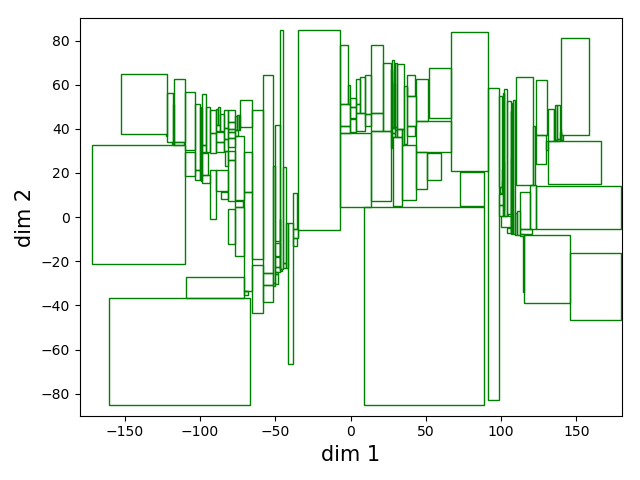

In [244]:
from Utils import *
#visualize_kdnodes_and_query_2(rtree_kdnodes2, [], [], domains)
visualize_kdnodes_and_query_2(rtree_kdnodes2, [], [], [[-180,180],[-90, 90]])

In [213]:
# idx3 = index.Index(DatasetGenerator(TWEET_dataset), properties = p2)

In [221]:
# idx3.leaves()[24][2]

[-84.9574, 82.9384, 84.1057, 178.352]

In [233]:
data_threshold = block_size
# BulkLoadMBRs = GenerateRtreePartitionUsingBulkLoading(dataset, maximum_capacity = data_threshold)
BulkLoadMBRs = GenerateRtreePartitionUsingBulkLoading(TWEET_dataset, maximum_capacity = data_threshold)
print(BulkLoadMBRs)

[[-9.93484e+01 -8.42753e+01  3.84077e+01  4.01959e+01  9.00000e+03]
 [ 3.25316e+01  9.85072e+01  3.87255e+01  3.99553e+01  9.00000e+03]
 [-8.42739e+01 -7.37292e+01  3.93934e+01  4.01527e+01  9.00000e+03]
 [ 1.09717e+02  1.33089e+02  3.72844e+01  4.30495e+01  9.00000e+03]
 [-2.67615e-01  3.25117e+01  3.97757e+01  4.06940e+01  9.00000e+03]
 [-8.42542e+01 -7.34965e+01  4.01528e+01  4.07034e+01  9.00000e+03]
 [-2.86259e+01 -3.80507e-01  3.80591e+01  4.30553e+01  9.00000e+03]
 [ 1.38476e+02  1.44459e+02  3.82166e+01  4.30565e+01  5.57000e+03]
 [-8.41599e+01 -7.34956e+01  4.07034e+01  4.07653e+01  9.00000e+03]
 [-2.68137e-01  3.24829e+01  4.06940e+01  4.09267e+01  9.00000e+03]
 [ 9.49842e+00  3.20766e+01  4.09268e+01  4.09864e+01  9.00000e+03]
 [ 9.22632e-01  3.11861e+01  4.09865e+01  4.10092e+01  9.00000e+03]
 [ 1.88728e-01  3.18731e+01  4.10092e+01  4.10322e+01  9.00000e+03]
 [-1.55860e-01  3.11866e+01  4.10322e+01  4.10658e+01  9.00000e+03]
 [-1.00223e+02 -8.42977e+01  4.01961e+01  4.1910

In [234]:
rtree_kdnodes = PartitionFormalization(BulkLoadMBRs)

In [235]:
detect_overlap(rtree_kdnodes)

overlap detect: 0 21 [[-99.3484, -84.2753], [38.4077, 40.1959]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 1 21 [[32.5316, 98.5072], [38.7255, 39.9553]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 2 21 [[-84.2739, -73.7292], [39.3934, 40.1527]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 3 21 [[109.717, 133.089], [37.2844, 43.0495]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 4 21 [[-0.267615, 32.5117], [39.7757, 40.694]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 5 21 [[-84.2542, -73.4965], [40.1528, 40.7034]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 6 21 [[-28.6259, -0.380507], [38.0591, 43.0553]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 7 21 [[138.476, 144.459], [38.2166, 43.0565]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 8 21 [[-84.1599, -73.4956], [40.7034, 40.7653]] [[-124.208, 148.869], [39.3675, 46.4825]]
overlap detect: 9 21 [[-0.268137, 32.4829], [40.694,

In [236]:
# print(rtree_kdnodes[0])
# print(rtree_kdnodes[1])
# print(rtree_kdnodes[2])
# print(rtree_kdnodes[3])
# print(rtree_kdnodes[4])
# print(rtree_kdnodes[5])
# print(rtree_kdnodes[6])

<IPython.core.display.Javascript object>


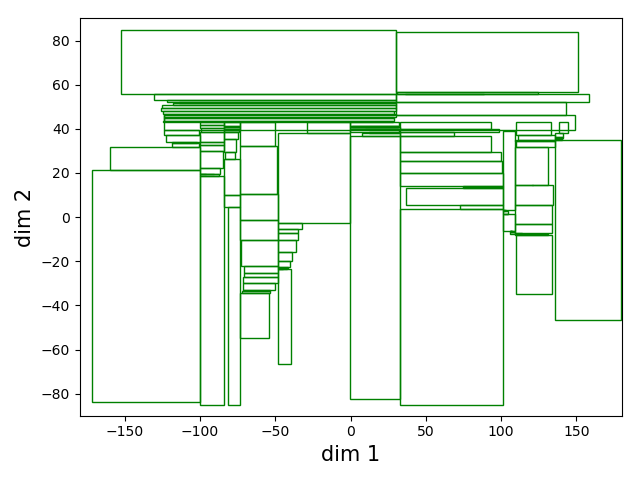

In [237]:
# = = = Visualization = = =
from Utils import *
# visualize_kdnodes_and_query_2(rtree_kdnodes, [], [], domains)
visualize_kdnodes_and_query_2(rtree_kdnodes, [], [], [[-180,180],[-90, 90]])

In [232]:
len(rtree_kdnodes)

129

In [62]:
# from Query import *
# Query(testing_set, rtree_kdnodes, random_percentage)